In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
# from utils.evaluation import find_landfalling_tcs,tc_region

In [2]:
# open storm dataset
tc_dir = '/user/home/al18709/work/event_sets/wgan_scalar/'
storm_filename = 'validation_2006237N13298.nc'
storm = xr.open_dataset(tc_dir + storm_filename)

In [3]:
# define initial variables
precip_cmap,precip_norm = make_cmap()

lats = storm.storm_lats[0,:,:]
lons = storm.storm_lons[0,:,:]

levels = [10, 15, 20, 25, 30, 40, 50,75, 100]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=100

print(lats.shape)
print(lons.shape)


ntime,_,_,_ = storm.precipitation.shape
rain = storm.precipitation[0,:,:,0]


(100, 100)
(100, 100)


In [4]:
# find storm extent
fp = '/bp1store/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon
lat_lower_bound = (np.abs(lat-np.min(storm.storm_lats))).argmin()
lat_upper_bound = (np.abs(lat-np.max(storm.storm_lats))).argmin()
lon_lower_bound = (np.abs(lon-np.min(storm.storm_lons))).argmin()
lon_upper_bound = (np.abs(lon-np.max(storm.storm_lons))).argmin()

lats = lat[lat_lower_bound:lat_upper_bound+2]
lons = lon[lon_lower_bound:lon_upper_bound+2]
grid_x, grid_y = np.meshgrid(lons,lats)
print(grid_x.shape)
print(grid_y.shape)

(326, 252)
(326, 252)


In [5]:
# superimpose rain onto bigger grid
grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))

for t in range(ntime):

	storm_lons = storm.storm_lons[t,:,:]
	storm_lats = storm.storm_lats[t,:,:]
	storm_rain = storm.precipitation[t,:,:,0]

	Mlon = storm_lons[-1,-1]
	mlon = storm_lons[0,0]
	Mlat = storm_lats[-1,-1]
	mlat = storm_lats[0,0]
	Xspan = np.where((grid_x <= Mlon) & (grid_x >= mlon))[1][[0, -1]]
	Yspan = np.where((grid_y <= Mlat) & (grid_y >= mlat))[0][[0, -1]]

	# Create a selection
	sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]
	# sel = [slice(Xspan[0] - 1, Xspan[1]), slice(Yspan[0] - 1, Yspan[1])]
	# sel = [slice(Yspan[0] -1, Yspan[1] + 1), slice(Xspan[0]-1, Xspan[1] + 1)]

	# grid_rain[t,sel[0],sel[1]] = storm_rain
	grid_rain[t,sel[1],sel[0]] = storm_rain
	

In [6]:
total_storm_rain = np.sum(grid_rain,axis=0)
rain_bool = total_storm_rain > 0
print(np.sum(rain_bool))
rain_grid_x = grid_x[rain_bool]

49518


In [7]:
print(rain_grid_x.shape)

(49518,)


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, 'title')

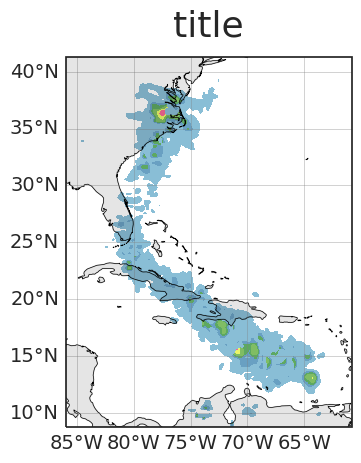

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

for t in range(ntime):
	c = ax.contourf(grid_x,grid_y,grid_rain[t,:,:],vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# ax.outline_patch.set_linewidth(0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# ax.set_xticklabels(labelsize=20)
# ax.set_yticklabels(labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

precip_cmap,precip_norm = make_cmap(high_vals=True)
# cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=ax)
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)


ax.set_title('title',fontsize=26,pad=15)

Text(0.5, 1.0, 'title')

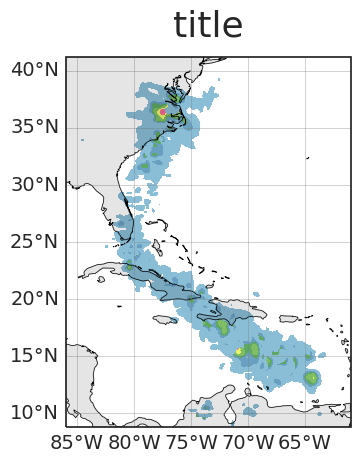

In [9]:

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

for t in range(ntime):
	c = ax.contourf(storm.storm_lons[t,:,:],storm.storm_lats[t,:,:],storm.precipitation[t,:,:,0],vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# ax.outline_patch.set_linewidth(0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# ax.set_xticklabels(labelsize=20)
# ax.set_yticklabels(labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

precip_cmap,precip_norm = make_cmap(high_vals=True)
# cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=ax)
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)


ax.set_title('title',fontsize=26,pad=15)


In [10]:
# need to use kerry's tracks for this because hit rate and false alarm rate are going to be sensitive to TCs moving over cities
# if there aren't many storms then the sensitivity will increase
# if there are loads of storms then this makes it a bit better

Text(0.5, 1.0, 'title')

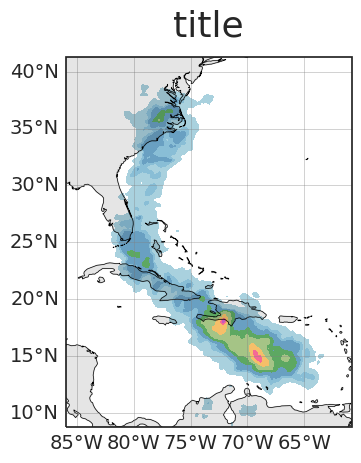

In [11]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=300


fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

ax.contourf(grid_x,grid_y,np.sum(grid_rain,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# ax.outline_patch.set_linewidth(0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# ax.set_xticklabels(labelsize=20)
# ax.set_yticklabels(labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

precip_cmap,precip_norm = make_cmap(high_vals=True)
# cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=ax)
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)


ax.set_title('title',fontsize=26,pad=15)

In [12]:
def exposure_calc(population, rain,threshold):
	""" number of people exposed to over 200mm in New York"""
	# population[rain['precipitation'] < 200] = 0
	print('max rain',np.max(rain['precipitation'].values))
	population = population.where(rain['precipitation'].values > threshold,0)
	exposure = np.nansum(population['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2])
	return exposure

In [13]:
accumulated_rain = np.sum(grid_rain,axis=0)

# population_file = '/user/home/al18709/work/population/gpw_v4_population_count_rev11_10km.nc'
# population_count = xr.load_dataset(population_file)
# print(population_count)
# data2 = population_count['Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values

# Mlon = grid_x[-1,-1]
# mlon = grid_x[0,0]
# Mlat = grid_y[-1,-1]
# mlat = grid_y[0,0]
# Xspan = np.where((grid_x <= Mlon) & (grid_x >= mlon))[1][[0, -1]]
# Yspan = np.where((grid_y <= Mlat) & (grid_y >= mlat))[0][[0, -1]]

# # Create a selection
# sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]
# print(data2.shape)
# cropped_pop = pop.sel(latitude=slice(mlat,Mlat), longitude=slice(mlon,Mlon)).values[2]
# cropped_pop = pop.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))

In [14]:
population_file = '/user/home/al18709/work/population/gpw_v4_population_count_rev11_2pt5_min.nc'
population_count = xr.load_dataset(population_file)
print(population_count)
data = population_count['Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2,:,:]
pop_lats = population_count.latitude
pop_lons = population_count.longitude

<xarray.Dataset>
Dimensions:                                                                  (
                                                                              longitude: 8640,
                                                                              latitude: 4320,
                                                                              raster: 20)
Coordinates:
  * longitude                                                                (longitude) float64 ...
  * latitude                                                                 (latitude) float64 ...
  * raster                                                                   (raster) int32 ...
Data variables:
    Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes  (raster, latitude, longitude) float32 ...
Attributes:
    proj4:        +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0...
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 2.8-4)

Text(0.5, 1.0, 'title')

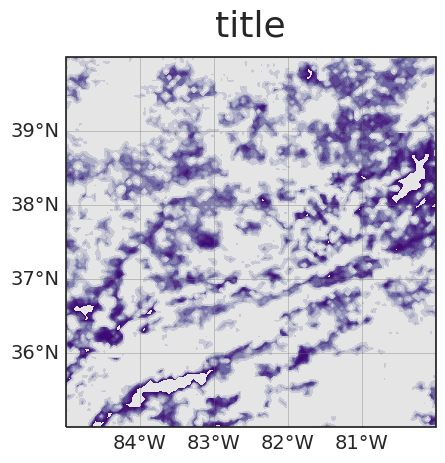

In [21]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=4000


fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

ax.contourf(population_count.longitude,population_count.latitude,data[:,:], vmin=0,vmax=350,levels=levels,cmap='Purples_r',transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# ax.outline_patch.set_linewidth(0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# ax.set_xticklabels(labelsize=20)
# ax.set_yticklabels(labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

precip_cmap,precip_norm = make_cmap(high_vals=True)
# cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=ax)
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)
ax.set_extent([-85, -80, 35, 40], crs=ccrs.PlateCarree())

ax.set_title('title',fontsize=26,pad=15)

Text(0.5, 1.0, 'title')

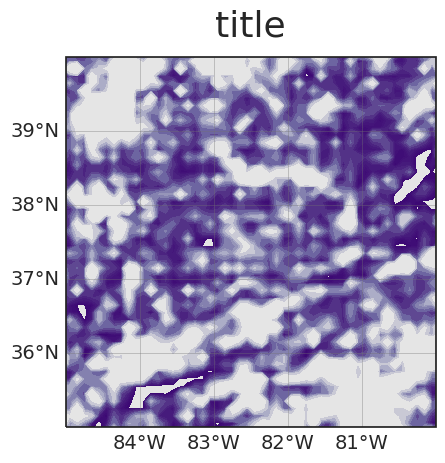

In [22]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=4000


fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

ax.contourf(population_count_regrid.lon,population_count_regrid.lat,data_regrid,vmax=350,levels=levels, cmap='Purples_r', vmin=0,transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# ax.outline_patch.set_linewidth(0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# ax.set_xticklabels(labelsize=20)
# ax.set_yticklabels(labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

precip_cmap,precip_norm = make_cmap(high_vals=True)
# cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=ax)
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)

ax.set_extent([-85, -80, 35, 40], crs=ccrs.PlateCarree())
ax.set_title('title',fontsize=26,pad=15)

Text(0.5, 1.0, 'title')

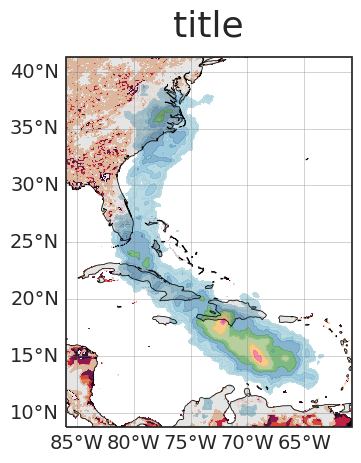

In [23]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=300


fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

ax.contourf(population_count.longitude,population_count.latitude,data,vmin=vmin,vmax=vmax,levels=levels, transform=ccrs.PlateCarree())
ax.contourf(grid_x,grid_y,np.sum(grid_rain,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)


ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# ax.outline_patch.set_linewidth(0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
# ax.set_xticklabels(labelsize=20)
# ax.set_yticklabels(labelsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

precip_cmap,precip_norm = make_cmap(high_vals=True)
# cbar = plt.colorbar(c,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=ax)
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)

ax.set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
ax.set_title('title',fontsize=26,pad=15)